### Libs & Data

In [1]:
import pandas as pd
import numpy as np
import os
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import string
import random
import unicodedata
from string import punctuation
from string import digits
from nltk.stem import WordNetLemmatizer
import joblib

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

import torch
from transformers import BartTokenizer, BartForConditionalGeneration, BartConfig

import spacy
from spacy.matcher import Matcher

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kwsst\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kwsst\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df_nk = pd.read_csv("data/df_nk.csv")
df_politics = pd.read_csv("data/df_politics.csv")
df_nk.shape

(2879, 9)

In [3]:
df_nk.head()

,Unnamed: 0,title,author,time,description,body,section,summarized_body,agg_title_body
0,3,[Newsmaker] Panamanian vessel probed over susp...,Yonhap,2017-12-31 14:55:00,PYEONGTAEK -- South Korea has seized and insp...,PYEONGTAEK -- South Korea has seized and insp...,North Korea,"The 5,100-ton KOTI is being held in the wester...",[Newsmaker] Panamanian vessel probed over susp...
1,7,Secret Sauce? Kim Jong-un applies science to k...,AP,2017-12-30 12:10:00,Kim Jong Un wants to turn the art of kimchi-ma...,Kim Jong Un wants to turn the art of kimchi-ma...,North Korea,"Ryugyong Kimchi Factory produces 4,200 tons of...",Secret Sauce? Kim Jong-un applies science to k...
2,8,N. Korea says there will be no change to its n...,Yonhap,2017-12-30 10:31:00,North Korea will continue to enhance its nucle...,North Korea will continue to enhance its nucle...,North Korea,North Korea will continue to enhance its nucle...,N. Korea says there will be no change to its n...
3,14,"Top diplomats of S. Korea, US reassure peacefu...",Yonhap,2017-12-29 16:31:00,The top diplomats of South Korea and the Unite...,The top diplomats of South Korea and the Unite...,North Korea,Top diplomats of South Korea and the U.S. held...,"Top diplomats of S. Korea, US reassure peacefu..."
4,19,Businessmen call for probe into shutdown of fa...,Yonhap,2017-12-29 15:04:00,A private task force on Friday pressed the gov...,A private task force on Friday pressed the gov...,North Korea,South Korea pulled the plug on the factory par...,Businessmen call for probe into shutdown of fa...


In [4]:
df_politics.shape

(2489, 9)

In [5]:
df_politics.head()

,Unnamed: 0,title,author,time,description,body,section,summarized_body,agg_title_body
0,21,Special pardons aimed at helping ordinary peop...,Yonhap,2017-12-29 11:39:00,"The latest pardon extended to more than 6,000 ...","The latest pardon extended to more than 6,000 ...",Politics,"The latest pardon extended to more than 6,000 ...",Special pardons aimed at helping ordinary peop...
1,34,[News Focus] Is multiparty system viable in Ko...,Jo He-rim,2017-12-28 16:29:00,A four-day vote of confidence in the People’s ...,A four-day vote of confidence in the People’s ...,Politics,A four-day vote of confidence in the People’s ...,[News Focus] Is multiparty system viable in Ko...
2,37,Political parties call on government to resolv...,Jo He-rim,2017-12-28 16:13:00,Political parties on Thursday expressed anger ...,Political parties on Thursday expressed anger ...,Politics,Political parties on Thursday expressed anger ...,Political parties call on government to resolv...
3,84,Korea's ODA project tainted by corruption scan...,Yonhap,2017-12-26 16:02:00,Impeached President Park Geun-hye's close frie...,Impeached President Park Geun-hye's close frie...,Politics,The probe looked into allegations that the pri...,Korea's ODA project tainted by corruption scan...
4,174,Ex-President Park summoned for questioning Friday,Ock Hyun-ju,2017-12-20 17:51:00,The prosecution summoned former President Park...,The prosecution summoned former President Park...,Politics,The prosecution summoned former President Park...,Ex-President Park summoned for questioning Fri...


### Import the embedded documents

In [6]:
vects_nk = joblib.load('data/tfidf_nk.csv')
vects_politics = joblib.load('data/tfidf_politics.csv')
print(vects_nk.shape, vects_politics.shape)

(2879, 300) (2489, 300)


### Clustering

In [8]:
### Clustering 
def document_clustering(doc_vectors, clustering_method='kmeans', epsilon=0.4, evaluate=False):
    if clustering_method=='kmeans':
        # Hyperparameters
        k_event = 10000
        k_issue = 6000
        
        # Clustering event
        kmeans_event = KMeans(n_clusters=k_event, random_state=69).fit(doc_vectors)
        # Represent each event by average sum of related news
        event_vectors = np.zeros((k_event, doc_vectors.shape[1]))
        for i in range(k_event):
            event_vectors[i] = sum(doc_vectors[kmeans_event.labels_ == i])
        
        # Clustering issue
        kmeans_issue = KMeans(n_clusters=k_issue, random_state=69).fit(event_vectors)
        # Represent each issue by average sum of related news
        issue_vectors = np.zeros((k_issue, doc_vectors.shape[1]))
        for i in range(k_issue):
            issue_vectors[i] = sum(event_vectors[kmeans_issue.labels_ == i])

        issue_labels = np.array([ kmeans_issue.labels_[kmeans_event.labels_[i]] for i in range(doc_vectors.shape[0]) ])
        
        return k_issue, k_event, issue_labels, kmeans_event.labels_
    
    elif clustering_method=='DBSCAN':
        
        # Hyperparameters
        doc_eps = 0.255
        doc_neighbors = 1
        event_eps = epsilon
        event_neighbors = 1
        
        '''
            Find best doc_eps and event_eps
        '''
        if evaluate:
            # Find best eps to group same document
            doc_eps_list = [ 0.2 + 0.001*i for i in range(1,601) ]
            doc_score = []
            doc_event = []
            doc_best_score = 0
            doc_best_eps = 0.0001
            for doc_eps in doc_eps_list:
                # Clustering event
                db_event = DBSCAN(eps=doc_eps, min_samples=doc_neighbors).fit(doc_vectors)
                # Number of clusters in labels, ignoring noise if present.
                n_events_ = len(set(db_event.labels_)) - (1 if -1 in db_event.labels_ else 0)
                if len(set(db_event.labels_)) >= 2 and len(set(db_event.labels_)) <= len(doc_vectors)-1:
                    score_ = silhouette_score(doc_vectors, db_event.labels_)
                else:
                    score_ = -1
                doc_event.append(n_events_)
                doc_score.append(score_)
                if score_ > doc_best_score:
                    doc_best_score = score_
                    doc_best_eps = doc_eps
            print("Best Silhouete score is {} at eps: {} and number of events: {}".format(doc_best_score, doc_eps, n_events_))
            fig = plt.figure()
            plt.plot(doc_eps_list, doc_score)
            fig.suptitle('Doc eps and Silhouette score', fontsize=20)
            plt.xlabel('eps', fontsize=18)
            plt.ylabel('Silhouette score', fontsize=16)
            plt.show()
            
            fig = plt.figure()
            plt.plot(doc_eps_list, doc_event)
            fig.suptitle('Doc eps and number of events', fontsize=20)
            plt.xlabel('eps', fontsize=18)
            plt.ylabel('number of events', fontsize=16)
            plt.show()
            
            # Set doc_eps to the best value
            doc_eps = doc_best_eps
            # Find best eps to group same event
            # Clustering event
            db_event = DBSCAN(eps=doc_eps, min_samples=doc_neighbors).fit(doc_vectors)
            n_events_ = len(set(db_event.labels_)) - (1 if -1 in db_event.labels_ else 0)
            event_labels = np.array(list(map(lambda x: n_events_ if x==-1 else x, db_event.labels_)))
            event_vectors = np.zeros((n_events_, doc_vectors.shape[1]))
            for i in range(n_events_+1):
                if np.sum(event_labels == i) != 0:
                    event_vectors[i] = np.sum(doc_vectors[event_labels == i], axis=0)/np.sum(event_labels == i)
            
            # Clustering issue
            event_eps_list = [ 0.2 + 0.001*i for i in range(1,601) ]
            event_score = []
            event_issue = []
            event_best_score = 0
            event_best_eps = 0.001
            for event_eps in event_eps_list:
                db_issue = DBSCAN(eps=event_eps, min_samples=event_neighbors).fit(event_vectors)
                # Number of clusters in labels, ignoring noise if present.
                n_issues_ = len(set(db_issue.labels_)) - (1 if -1 in db_issue.labels_ else 0)
                if len(set(db_issue.labels_)) >= 2 and len(set(db_issue.labels_)) <= len(event_vectors)-1:
                    score_ = silhouette_score(event_vectors, db_issue.labels_)
                else:
                    score_ = -1
                event_issue.append(n_issues_)
                event_score.append(score_)
                if score_ > event_best_score:
                    event_best_score = score_
                    event_best_eps = event_eps
            print("Best Silhouete score is {} at eps: {} and number of issues: {}".format(event_best_score, event_eps, n_issues_))
            fig = plt.figure()
            plt.plot(event_eps_list, event_score)
            fig.suptitle('Event eps and Silhouette score', fontsize=20)
            plt.xlabel('eps', fontsize=18)
            plt.ylabel('Silhouette score', fontsize=16)
            plt.show()
            
            fig = plt.figure()
            plt.plot(event_eps_list, event_issue)
            fig.suptitle('Event eps and number of issues', fontsize=20)
            plt.xlabel('eps', fontsize=18)
            plt.ylabel('number of issues', fontsize=16)
            plt.show()
            
            # Set event_eps to best value
            event_eps = event_best_eps
            # Clustering issue
            db_issue = DBSCAN(eps=event_eps, min_samples=event_neighbors).fit(event_vectors)
            # Number of clusters in labels, ignoring noise if present.
            n_issues_ = len(set(db_issue.labels_)) - (1 if -1 in db_issue.labels_ else 0)
            n_noise_ = list(db_issue.labels_).count(-1)
            print(n_issues_, n_noise_)
            # Represent each issue by average sum of related news
            issue_labels = np.array(list(map(lambda x: n_issues_ if x==-1 else x, db_issue.labels_)))
            issue_vectors = np.zeros((n_issues_, doc_vectors.shape[1]))
            for i in range(n_issues_+1):
                if np.sum(issue_labels == i) != 0:
                    issue_vectors[i] = np.sum(event_vectors[issue_labels == i], axis=0)/np.sum(issue_labels == i)
       
            issue_labels = np.array([ issue_labels[event_labels[i]] for i in range(doc_vectors.shape[0]) ])
        
        else:
            '''
            Clustering using specific value
            '''
            # Clustering event
            db_event = DBSCAN(eps=doc_eps, min_samples=doc_neighbors).fit(doc_vectors)
            # Number of clusters in labels, ignoring noise if present.
            n_events_ = len(set(db_event.labels_)) - (1 if -1 in db_event.labels_ else 0)
            n_noise_ = list(db_event.labels_).count(-1)
            print(n_events_, n_noise_)
            # Represent each event by average sum of related news
            event_labels = np.array(list(map(lambda x: n_events_ if x==-1 else x, db_event.labels_)))
            event_vectors = np.zeros((n_events_, doc_vectors.shape[1]))
            for i in range(n_events_+1):
                if np.sum(event_labels == i) != 0:
                    event_vectors[i] = np.sum(doc_vectors[event_labels == i], axis=0)/np.sum(event_labels == i)

            # Clustering issue
            db_issue = DBSCAN(eps=event_eps, min_samples=event_neighbors).fit(event_vectors)
            # Number of clusters in labels, ignoring noise if present.
            n_issues_ = len(set(db_issue.labels_)) - (1 if -1 in db_issue.labels_ else 0)
            n_noise_ = list(db_issue.labels_).count(-1)
            print(n_issues_, n_noise_)
            # Represent each issue by average sum of related news
            issue_labels = np.array(list(map(lambda x: n_issues_ if x==-1 else x, db_issue.labels_)))
            issue_vectors = np.zeros((n_issues_, doc_vectors.shape[1]))
            for i in range(n_issues_+1):
                if np.sum(issue_labels == i) != 0:
                    issue_vectors[i] = np.sum(event_vectors[issue_labels == i], axis=0)/np.sum(issue_labels == i)
        
            issue_labels = np.array([ issue_labels[event_labels[i]] for i in range(doc_vectors.shape[0]) ])
        
        return n_issues_, n_events_, issue_labels, event_labels
    
    elif clustering_method=='agglomerative':
        
        pass
    
    elif clustering_method=='LDA':
        
        pass
    
    else:
        assert("Doesn't support {}".format(clustering_method))

Best Silhouete score is 0.0770873620107604 at eps: 0.8 and number of events: 1


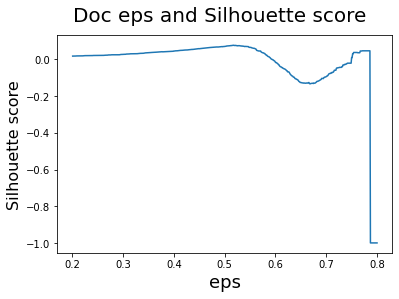

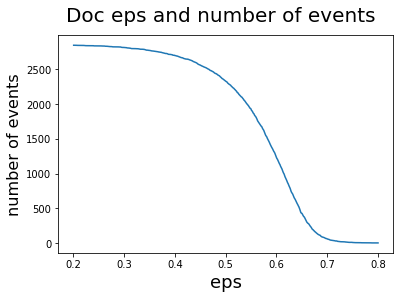

Best Silhouete score is 0.12282687449817256 at eps: 0.8 and number of issues: 2


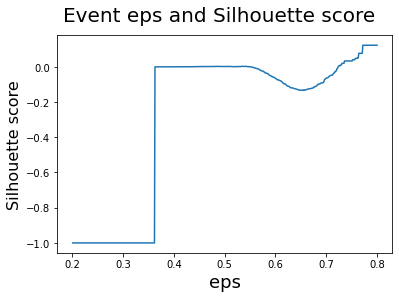

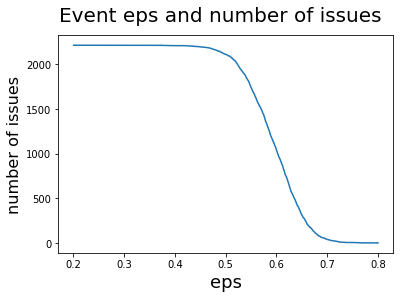

2 0


In [10]:
num_issue_nk, num_event_nk, issue_labels_nk, event_labels_nk = document_clustering(vects_nk,
                                                                                   clustering_method='DBSCAN',
                                                                                   evaluate=True)

Best Silhouete score is 0.08047020454150436 at eps: 0.8 and number of events: 2


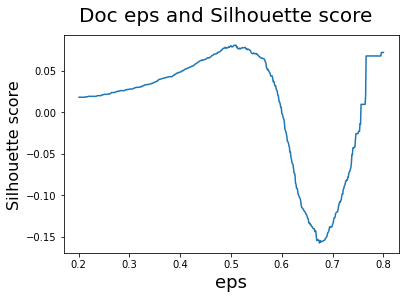

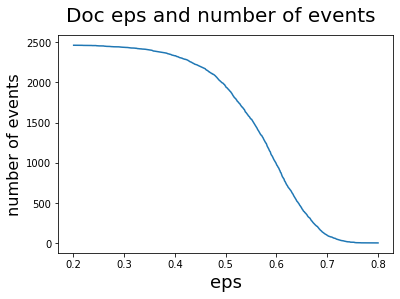

Best Silhouete score is 0.049221383679672624 at eps: 0.8 and number of issues: 1


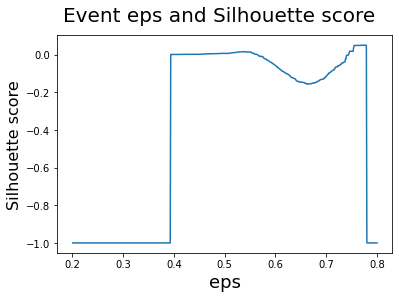

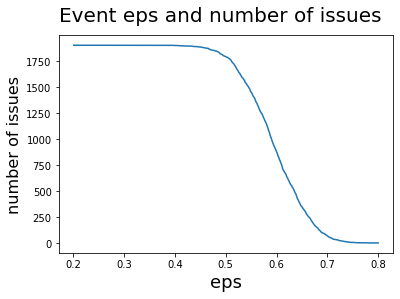

2 0


In [11]:
num_issue_politics, num_event_politics, issue_labels_politics, event_labels_politics = document_clustering(vects_politics,
                                                                                   clustering_method='DBSCAN',
                                                                                   evaluate=True)

In [47]:
num_issue_nk, num_event_nk, issue_labels_nk, event_labels_nk = document_clustering(vects_nk,
                                                                                   clustering_method='DBSCAN',
                                                                                   epsilon=0.47,
                                                                                   evaluate=False)

2837 0
2484 0


In [48]:
num_issue_politics, num_event_politics, issue_labels_politics, event_labels_politics = document_clustering(vects_politics,
                                                                                   clustering_method='DBSCAN',
                                                                                   epsilon=0.48,
                                                                                   evaluate=False)

2454 0
2080 0


In [49]:
df_nk['label'] = issue_labels_nk
df_politics['label'] = issue_labels_politics

In [50]:
# get top n most frequent labels
n = 10
label_nk = df_nk['label'].value_counts()[:n].index.tolist()
label_politics = df_politics['label'].value_counts()[:n].index.tolist()
print(label_nk)
print(label_politics)

[100, 1265, 547, 2216, 203, 778, 1403, 13, 751, 342]
[360, 642, 1212, 1329, 37, 1939, 28, 525, 1373, 1504]


In [51]:
def freq_label(df, labels):
    freqs = []
    for label in labels:
        freq = df.loc[df.label == label, 'label'].count()
        freqs.append(freq)
    return freqs
print(freq_label(df_nk, label_nk))
print(freq_label(df_politics, label_politics))

[13, 13, 10, 9, 8, 7, 7, 7, 6, 6]
[11, 9, 9, 8, 8, 8, 7, 7, 7, 7]


In [65]:
# Concat the sentences in each group and make a summary
def concat_sents(df, label):
    sents = []
    for i in label:
        s = ''
        for sentence in df[df['label'] == i]['summarized_body'].tolist():
            s += sentence
        sents.append(s)
    print(len(sents))
    return sents

In [66]:
sents_nk = concat_sents(df_nk, label_nk)
sents_nk

10


['North Korea appears to be advancing its submarine-launched ballistic missile (SLBM) program, a U.S. website says. Commercial satellite imagery shows the country\'s second platform for launching missiles underwater outside of submarines has been moved. The platform, known as a submersible ballistic missile test stand barge, "is being prepared to enter service," 38 North says.Recent satellite imagery indicates new activity at the test stand of North Korea\'s main submarine-launched ballistic missile development shipyard. The April 29 imagery of the Sinpo South Shipyard shows a heavy-lift crane with its stabilizer legs deployed. The test stand was used during 2014-2016 for launch systems verification, and pop-up and prototype testing of the Pukguksong-1.North Korea is building a new bigger class of submarine than the existing Sinpo-class, an analyst says. The new project seems to have been kicked off several years ago, he says. On Wednesday, North Korea launched an SLBM from the East Se

In [67]:
sents_politics = concat_sents(df_politics, label_politics)
sents_politics

10


["Moon Jae-in of the liberal Democratic Party remained the front-runner in South Korea's presidential race. The former opposition leader gained 34.4 percent last week, down 2.2 percentage points from the previous week. The decline was possibly due to voter backlash over increased mudslinging among the party's four contenders.Moon Jae-in of the liberal Democratic Party garnered a record 36.6 percent approval rating last week. The former leader of the largest party in the National Assembly rose 1.5 percentage points in a weekly survey. Moon has maintained the lead for 11 consecutive weeks. The election landscape has tilted strongly in favor of theLiberal camp after conservative President Park Geun-hye was removed from office over a corruption scandal.Moon Jae-in, the front-runner presidential hopeful from the Democratic Party, remained the most favored contender. South Gyeongsang Gov. Hong Joon-pyo rose as a strong conservative figure after the acting president decided not to enter the r

In [60]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn').to(device)
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

In [61]:
def summarize_text(s: str):
    inputs = tokenizer([s], max_length=1024, return_tensors='pt', truncation=True).to(device)
    summary_ids = model.generate(inputs['input_ids'], num_beams=4, max_length=100, early_stopping=True)
    output = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]
    torch.cuda.empty_cache()
    return output[0]

In [63]:
def summarize(sents):
    summary = []
    for sent in sents:
        summary.append(summarize_text(sent))
    return summary

In [70]:
summary_nk = summarize(sents_nk)
summary_nk

['North Korea appears to be advancing its submarine-launched ballistic missile program. Commercial satellite imagery shows the country\'s second platform for launching missiles underwater outside of submarines has been moved. The platform, known as a submersible ballistic missile test stand barge, "is being prepared to enter service," 38 North says.',
 "Group of 13 North Korean defectors who worked at a restaurant in China have begun to resettle in South Korea. Seoul's unification ministry said it cannot reveal further details due to concerns over their safety. Overseas restaurants are an increasingly important source of dollars for the North at a time when international sanctions have cut off Pyongyang.",
 'Around 200 propaganda leaflets from the North were found near Susaek Station in western Seoul late Saturday. The leaflets, promoting the “success of Hwasong-14 ICBM” were dropped over the South Korean capital. North Korea has been increasing its efforts to equip itself with ballist

In [71]:
summary_politics = summarize(sents_politics)
summary_politics

['Moon Jae-in of the liberal Democratic Party garnered a record 36.6 percent approval rating last week. The former leader of the largest party in the National Assembly rose 1.5 percentage points in a weekly survey. South Gyeongsang Gov. Hong Joon-pyo rose as a strong conservative figure after the acting president decided not to enter the race.',
 'Former UN Secretary-General Ban Ki-moon’s return home has brought him closer to his much anticipated bid for South Korean presidency. The 72-year-old former diplomat now enters domestic politics for the first time as a rookie in the electoral game. The two main conservative parties expressed shock and regret for losing their potential standard-bearer, while the opposition camp welcomed his decision.',
 "President Park Geun-hye on Friday granted special pardons to more than 4,800 convicts. Among the beneficiaries was Lee Jay-hyun, the chairman of the nation’s largest food and entertainment conglomerate CJ Group. The pardons are part of celebra

In [72]:
def top_n_sum(df, summary, label):
    topnsum = pd.DataFrame(summary, columns=['summary'])
    topnsum['label'] = label
    topnsum['freq'] = freq_label(df, label)
    return topnsum

In [78]:
top_nk = top_n_sum(df_nk, summary_nk, label_nk)
top_nk.to_csv("data/top_nk.csv", index=False)
df_nk.to_csv("data/df_nk_labeled", index=False)
top_nk

,summary,label,freq
0,North Korea appears to be advancing its submar...,100,13
1,Group of 13 North Korean defectors who worked ...,1265,13
2,Around 200 propaganda leaflets from the North ...,547,10
3,254 people of 90 families from the South met w...,2216,9
4,84 percent of Americans think President Donald...,203,8
5,UN nuclear watchdog should revise its view on ...,778,7
6,U.N. Security Council adopted Resolution 2270 ...,1403,7
7,IOC President Thomas Bach is seeking to visit ...,13,7
8,North Korea has featured a flight crew of its ...,751,6
9,Shallow 3.5-magnitude earthquake hits North Ko...,342,6


In [79]:
top_politics = top_n_sum(df_politics, summary_politics, label_politics)
top_politics.to_csv("data/top_politics.csv", index=False)
df_politics.to_csv("data/df_politics_labeled", index=False)
top_politics

,summary,label,freq
0,Moon Jae-in of the liberal Democratic Party ga...,360,11
1,Former UN Secretary-General Ban Ki-moon’s retu...,642,9
2,President Park Geun-hye on Friday granted spec...,1212,9
3,President Park Geun-hye vetoed the controversi...,1329,8
4,67.8 percent of respondents said they approved...,37,8
5,South Korean President Park Geun-hye returned ...,1939,8
6,Eight former renegade lawmakers returned to th...,28,7
7,Seoul court on Tuesday held the first preparat...,525,7
8,President Park Geun-hye arrived in Seoul on We...,1373,7
9,The Federation of Korean Trade Unions said Tue...,1504,7
